In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics.pairwise import cosine_similarity
import random

import nltk
import re
from sklearn.svm import SVC
from nltk.stem.lancaster import LancasterStemmer
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HIMANGSHUB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data reading

In [2]:
chatbot_df = pd.read_csv("Cleaned Dataset\\final-dataset.csv")
chatbot_df.head()

,Question,Answer,Intent
0,what does it mean to have a mental illness,Mental illnesses are health conditions that di...,mental_health
1,who does mental illness affect,It is estimated that mental illness affects 1 ...,mental_health
2,what causes mental illness,It is estimated that mental illness affects 1 ...,mental_health
3,what are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...,mental_health
4,can people with mental illness recover,"When healing from mental illness, early identi...",mental_health


## Function for the stemming the data

In [3]:
stemmer = LancasterStemmer()

In [4]:
def cleanup(sentence):
    sentence = sentence.lower()
    word_tok = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(w) for w in word_tok]
    return ' '.join(stemmed_words)

In [5]:
sentence = "Q: symptoms 6 of heart attack ?"
cleanup(sentence)

'q : symptom 6 of heart attack ?'

## tfidf and label encoding and stemming data

In [6]:
tfv = TfidfVectorizer(min_df=1, stop_words='english')
label_encode = LE()

In [7]:
input_data = chatbot_df["Question"]
output_data = chatbot_df["Intent"]

In [8]:
stemmed_input_data = []
for question in input_data:
    stemmed_input_data.append(cleanup(question))

In [9]:
tfv.fit(stemmed_input_data)
label_encode.fit(output_data)

input_vec = tfv.transform(stemmed_input_data)
output_le = label_encode.transform(output_data)

In [10]:
print(type(input_vec))
print(input_vec.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(721, 999)


### Spliting the data 

In [11]:
x_train,x_test,y_train,y_test = TTS(input_vec,output_le, test_size = .30 , random_state=30)

## Model implementation - SVM

In [12]:
model = SVC(kernel='linear')
model.fit(x_train, y_train)

SVC(kernel='linear')

In [13]:
# predicted value for the test data
y_pred = model.predict(x_test)


accuracy score: 87.557604
[[55  0  0  0  0  1  2]
 [ 2 34  0  0  0  0  1]
 [ 2  0 23  0  1  1  0]
 [ 3  0  0  1  0  0  0]
 [ 3  1  0  0 36  0  0]
 [ 2  0  0  0  1 17  0]
 [ 1  3  1  0  1  1 24]]


Text(0.5, 1.0, 'Confusion matrix')

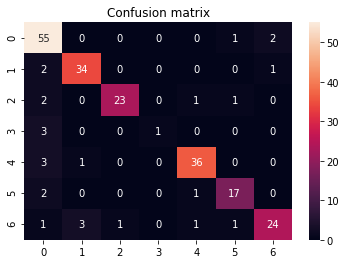

In [14]:
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,confusion_matrix
print("\naccuracy score: %f"%(accuracy_score(y_test,y_pred)*100))
print(confusion_matrix(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)
plt.title("Confusion matrix")

## Testing new query 

In [15]:
query = "sympto  attack"
stemmed_query = cleanup(query.strip())
query_vec = tfv.transform([stemmed_query])
pre = model.predict(query_vec)[0]
intent = label_encode.inverse_transform([pre])
intent

array(['heart'], dtype=object)

In [16]:
question_set = chatbot_df[ chatbot_df['Intent']==intent[0]]

## Apply Cosine Similarity to get the appropriate Answer

In [17]:
cos_sims = []
for question in question_set['Question']:
    sims = cosine_similarity(tfv.transform([cleanup(question.strip())]), query_vec)
    cos_sims.append(sims)

In [18]:
most_similar_question_index = cos_sims.index(max(cos_sims))

## output

In [19]:
# most similar question index 
question_set.iloc[most_similar_question_index]

Question                               treating heart attacks
Answer      Treating heart attacksWhile waiting for an amb...
Intent                                                  heart
Name: 572, dtype: object

## Function to get the top 5 Possible questions

In [20]:
def top_5_similar_qns(cos_sim_array):
    indx = []
    for ind , score in enumerate(cos_sim_array):
        indx.append([score[0][0] , ind])
    indx.sort(reverse=True)
    return indx[:5]
top_5_similar_qns(cos_sims)

[[0.6401609369318505, 1],
 [0.6368328367216328, 2],
 [0.6204418884233132, 0],
 [0.5907239410160834, 4],
 [0.5661838821593628, 123]]

## Response to not found any match

In [21]:
def not_found():
    print("Medicus: Sorry, I could not understand you question!")

## Function for Chat 

In [39]:
def ChatMatch(query):
    # clean the query
    query = cleanup(query.strip())
    # vectorized the query
    query_vec = tfv.transform([query])
    # predict the intent 
    pred = model.predict(query_vec)[0]
    intent = label_encode.inverse_transform([pred])
    # find the question set based on the intent classified 
    question_set = chatbot_df[ chatbot_df['Intent']==intent[0]]
    # apply cosine similarity to get the top 5 similar match
    cos_sims = []
    for question in question_set['Question']:
        sims = cosine_similarity(tfv.transform([question]), query_vec)
        cos_sims.append(sims)
    # top 5 questions with index and scores
    top_5_match = top_5_similar_qns(cos_sims)
    
    if(top_5_match[0][0] >= 0.5):
        max_score_idx = top_5_match[0][1]
        print(f"Medicus: {question_set.iloc[max_score_idx].Answer}")
        index = int(input(f"Medicus: Was this answer helpful? \n 1.Yes \n 2.No"))
        if(index==1):
            print("Medicus: Thank you.. Happy Reading !")
        else:
            print("Medicus: Hope the following helps :")
            print("Top five query based ob your search :")
            for idx in range(5):
                print(f"{idx+1}. {question_set.iloc[top_5_match[idx][1]].Question}")
            print("6. Not found")
            res = int(input("Select the questions Number.."))
            if(res==6):
                not_found()
            else:
                print(f"Medicus: {question_set.iloc[top_5_match[res-1][1]].Answer}" )
    else:
        not_found()
    

## CHATBOT STARTS

In [40]:
print("Medicus: Welcome to my world!")
chat = True 

while chat:
    query = input("Medicus: HELLO, Asked me anything about disease!")
    if query.lower() == 'bye':
        print("Medicus: Good Bye, Hope to see you again !")
        chat = False
    elif query:
        ChatMatch(query)
    else:
        chat == False

Medicus: Welcome to my world!
Medicus: Hello, Nice to meet you!
Hope the following helps :
Top five query based ob your search :
1. hello
2. bye
3. thank you
4. howdy
5. what is happening
6. Not found
Medicus: All good!
Medicus: The treatment options include medications, angioplasty and stent placement, atherectomy and coronary artery bypass grafting. The choice of treatment will depend on the extent of the disease.
Hope the following helps :
Top five query based ob your search :
1. what are treatment options available to treat heart attack
2. complications of a heart attack
3. recovering from a heart attack
4. causes of a heart attack
5. symptoms of a heart attack
6. Not found
Medicus: Symptoms of a heart attackSymptoms of a heart attack can include:chest pain a feeling of pressure, heaviness, tightness or squeezing across your chestpain in other parts of the body  it can feel as if the pain is spreading from your chest to your arms (usually the left arm, but it can affect both arms),

## Build model with Lemmatized data

In [25]:
# chatbot_df_lem = pd.read_csv("Cleaned Dataset\lemmatized-data.csv")
# input_data_lem = chatbot_df_lem["Question"]
# output_data_lem = chatbot_df_lem["Intent"]
# tfv.fit(input_data_lem)
# label_encode.fit(output_data_lem)
# input_vec_lem = tfv.transform(input_data_lem)
# output_le_lem = label_encode.transform(output_data_lem)
# x_train_lem,x_test_lem,y_train_lem,y_test_lem = TTS(input_vec_lem,output_le_lem, test_size = .30 , random_state=30)
# model_lem = SVC(kernel='linear')
# model_lem.fit(x_train_lem, y_train_lem)
# print("SVC Score:", model_lem.score(x_test_lem, y_test_lem))
